In [ ]:
import numpy as np
import math
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,GeoBounds, CoordPair,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)
from scipy.interpolate import griddata

In [73]:
##read wrf var
wrf_file = Dataset("/glade/scratch/mingzhu/High_res/WRF/run_e5/wrfout_d03_2006-01-19_11:00:00")
turbfile = Dataset("/glade/scratch/mingzhu/High_res/WRF/run_e5_turb/wrfout_d03_2006-01-19_07:00:00")
timec = 1
u = getvar(wrf_file, "ua", timeidx=timec)
v = getvar(wrf_file, "va", timeidx=timec)
w = getvar(wrf_file, "wa", timeidx=timec)
ht = getvar(wrf_file, "z", timeidx=timec)
ter = getvar(wrf_file, "ter", timeidx=timec)
snow = getvar(wrf_file, "SNOWNC", timeidx=timec)
timet = 5
u_t = getvar(turbfile, "ua", timeidx=timet)
v_t = getvar(turbfile, "va", timeidx=timet)
w_t = getvar(turbfile, "wa", timeidx=timet)
ht_t = getvar(turbfile, "z", timeidx=timet)
ter_t = getvar(turbfile, "ter", timeidx=timet)
snow_t = getvar(turbfile, "SNOWNC", timeidx=timet)
##function for find cross location
def crossloc(x1,y1,x2,y2):
    cross_start = CoordPair(x=x1, y=y1)
    cross_end = CoordPair(x=x2, y=y2)
    return cross_start,cross_end

x1 = [0,0,0,0,0]
y1 = [25,20,15,10,5]
x2 = [530,530,530,530,530]
y2 = [710,705,700,695,690]

st0, ed0 = crossloc(x1[0],y1[0],x2[0],y2[0])
st1, ed1 = crossloc(x1[1],y1[1],x2[1],y2[1])
st2, ed2 = crossloc(x1[2],y1[2],x2[2],y2[2])
st3, ed3 = crossloc(x1[3],y1[3],x2[3],y2[3])
st4, ed4 = crossloc(x1[4],y1[4],x2[4],y2[4])

def interp(st,ed):
    ter_line = interpline(ter, wrfin=wrf_file, start_point=st,
                          end_point=ed)
    snow_t_line = interpline(snow_t, wrfin=turbfile, start_point=st,
                             end_point=ed)
    snow_line = interpline(snow, wrfin=wrf_file, start_point=st,
                           end_point=ed)
    return ter_line, snow_line, snow_t_line

ter0, cont0, turb0 = interp(st0, ed0)
ter1, cont1, turb1 = interp(st1, ed1)
ter2, cont2, turb2 = interp(st2, ed2)
ter3, cont3, turb3 = interp(st3, ed3)
ter4, cont4, turb4 = interp(st4, ed4)

ter_ave = (ter0+ter1+ter2+ter3+ter4) /5
cont_ave = (cont0+cont1+cont2+cont3+cont4) /5
turb_ave = (turb0+turb1+turb2+turb3+turb4) /5
re = 100*(turb_ave-cont_ave)/cont_ave
    

Text(0.5, 1.0, 'Turb(red) and Cont(blue) Snow accumulation average and relative difference(black line)')

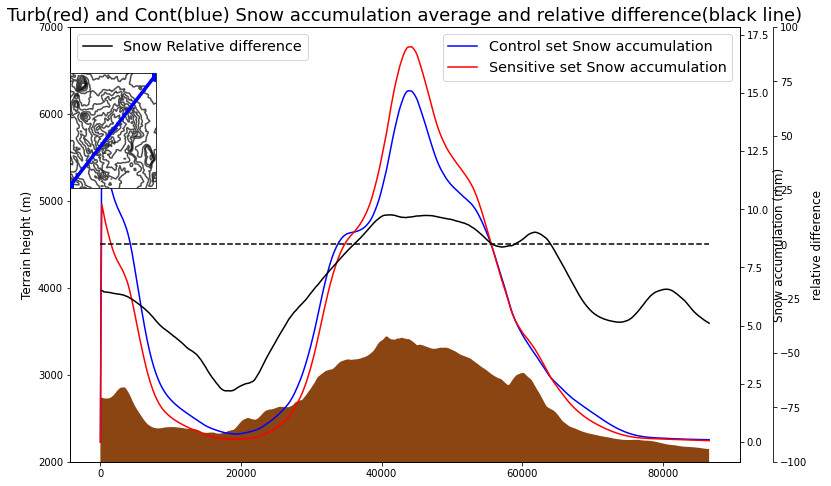

In [117]:
lats, lons = latlon_coords(u)
cart_proj = get_cartopy(u)
fig = pyplot.figure(figsize=(12, 8))
ax_ter = fig.add_subplot(1, 1, 1)
ax_cross = ax_ter.twinx()
ax_re = ax_ter.twinx()
ax_map = fig.add_axes([0.05, 0.60, 0.25, 0.20], projection=cart_proj)
ax_re.spines["right"].set_position(("axes", 1.05))
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax_map.add_feature(states, linewidth=.5, edgecolor="black")
ax_map.contour(to_np(lons), to_np(lats), to_np(ter), 10, colors="black",
                transform=crs.PlateCarree(),alpha=.7)
def plotmap(stn, edn):
    st_ll = xy_to_ll(wrf_file,stn.x, stn.y)
    ed_ll = xy_to_ll(wrf_file,edn.x, edn.y)
    ax_map.plot([st_ll[1], ed_ll[1]],
                [st_ll[0], ed_ll[0]], color="blue", marker="o",
                transform=crs.PlateCarree(),zorder=3)
plotmap(st0, ed0)
plotmap(st1, ed1)
plotmap(st2, ed2)
plotmap(st3, ed3)
plotmap(st4, ed4)
xs = np.arange(0, cont_ave.shape[-1], 1)*100
u_cross = vertcross(u, ht, wrfin=wrf_file,
                    start_point=st0,
                    end_point=ed0,
                    latlon=True, meta=True)
ys = to_np(u_cross.coords["vertical"])
snow_contours = ax_cross.plot(xs, cont_ave, "b", label = 'Control set Snow accumulation')
snow_contours_t = ax_cross.plot(xs, turb_ave, "r", label = 'Sensitive set Snow accumulation')
diff = ax_re.plot(to_np(xs), to_np(re), "k", label = 'Snow Relative difference')
ze = xs * 0
ax_re.plot(to_np(xs), to_np(ze), "k--")
ht_fill = ax_ter.fill_between(xs, 0, to_np(ter_ave),
                                facecolor="saddlebrown")
ax_re.legend(loc = 'upper left', fontsize = 'x-large')
ax_cross.legend(loc = 'best', fontsize = 'x-large')
ax_ter.set_ylim([2000, 7000])
ax_re.set_ylim([-100, 100])
ax_cross.set_xlabel("Distance to start point", fontsize=12)
ax_cross.set_ylabel("Snow accumulation (mm)", fontsize=12)
ax_ter.set_ylabel("Terrain height (m)", fontsize=12)
ax_re.set_ylabel("relative difference", fontsize=12)
# Add a title
ax_cross.set_title(
    "Turb(red) and Cont(blue) Snow accumulation average and relative difference(black line)",
    {"fontsize": 18})
pyplot.savefig('e5/snowline_test18%02d' % (times+11) + '.png')